<a href="https://colab.research.google.com/github/tracyhua2/DS3001/blob/main/Labs/Lab_2_Machine_Learning_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Name:** Tracy Hua

## **Computing ID:** njn4gb

# Lab 2: Machine Learning Evaluation (100 Points)

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB

# **Candidate Messy Datasets for Part 1:**
* Tidy Tuesday
   * https://github.com/rfordatascience/tidytuesday/tree/main/data
* Hugging Face
   * https://huggingface.co/datasets/nateraw/airplane-crashes-and-fatalities
* Kaggle
   * https://www.kaggle.com/datasets/borapajo/food-choices?select=food_coded.csv
   * https://www.kaggle.com/datasets/mahnazarjmand/breast-cancer-data?resource=download




## Part 1: KNN and Regression Model Evaluation (30 Points)

## **Question 1 (15 points):**
## Read in or load a dataset as a Pandas DataFrame with at least 5 features (columns) and a categorical target column.

## Create a new DataFrame called clean_df that incorporates these preprocessing steps in **separate cells**. Complete each step regardless of if they have no effect on your data:
0. Call dtypes on the DataFrame
1. Drop rows that are completely empty
2. Replace missing values ("null", 0, empty strings) with proper NaNs
3. Impute NaNs using any method that sklearn supports
4. Drop any features that seem highly uncorrelated to your target so long as you still retain at least 5 features
5. Normalize and/or scale numerical columns using any method that sklearn supports
6. Encode any categorical columns using appropriate method (ordinal, one hot encoding)
7. Any additional preprocessing required for your data (ie: removing dollar signs from string columns and casting it is a float)

In [56]:
food_url = "https://raw.githubusercontent.com/tracyhua2/DS3001/refs/heads/main/Data/food_coded.csv"

food_df = pd.read_csv(food_url)

food_df.head()

,GPA,Gender,breakfast,calories_chicken,calories_day,calories_scone,coffee,comfort_food,comfort_food_reasons,comfort_food_reasons_coded,...,soup,sports,thai_food,tortilla_calories,turkey_calories,type_sports,veggies_day,vitamins,waffle_calories,weight
0,2.4,2,1,430,NaN,315.0,1,none,we dont have comfort,9.0,...,1.0,1.0,1,1165.0,345,car racing,5,1,1315,187
1,3.654,1,1,610,3.0,420.0,2,"chocolate, chips, ice cream","Stress, bored, anger",1.0,...,1.0,1.0,2,725.0,690,Basketball,4,2,900,155
2,3.3,1,1,720,4.0,420.0,2,"frozen yogurt, pizza, fast food","stress, sadness",1.0,...,1.0,2.0,5,1165.0,500,none,5,1,900,I'm not answering this.
3,3.2,1,1,430,3.0,420.0,2,"Pizza, Mac and cheese, ice cream",Boredom,2.0,...,1.0,2.0,5,725.0,690,NaN,3,1,1315,"Not sure, 240"
4,3.5,1,1,720,2.0,420.0,2,"Ice cream, chocolate, chips","Stress, boredom, cravings",1.0,...,1.0,1.0,4,940.0,500,Softball,4,2,760,190


In [57]:
# Make copy of clean dataframe
clean_df = food_df.copy()

# Call data types on the dataframe
clean_df.dtypes

,0
GPA,object
Gender,int64
breakfast,int64
calories_chicken,int64
calories_day,float64
...,...
type_sports,object
veggies_day,int64
vitamins,int64
waffle_calories,int64


In [58]:
# 1. Drop rows that are completely empty
clean_df.dropna(how='all', inplace=True)

# 2. Replace missing values with proper NaNs
clean_df.replace(["nan", "null", 0, "", "none", "I'm not answering this. ", "Unknown"],
                 np.nan, inplace=True)

# Drop non-numerical features
clean_df.drop(["comfort_food", "comfort_food_reasons", "diet_current", "eating_changes",
               "father_profession", "fav_cuisine", "food_childhood", "healthy_meal",
               "ideal_diet","meals_dinner_friend", "mother_profession", "type_sports"],
              axis=1, inplace=True)

# Fix the data strings and data type
clean_df.replace(["Not sure, 240", "144 lbs"], [240, 144], inplace=True)
def convert_numeric(df):
  for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')
  return df
clean_df = convert_numeric(clean_df)
clean_df.head()

,GPA,Gender,breakfast,calories_chicken,calories_day,calories_scone,coffee,comfort_food_reasons_coded,cook,comfort_food_reasons_coded.1,...,self_perception_weight,soup,sports,thai_food,tortilla_calories,turkey_calories,veggies_day,vitamins,waffle_calories,weight
0,2.400,2,1,430,NaN,315.0,1,9.0,2.0,9,...,3.0,1.0,1.0,1,1165.0,345,5,1,1315,187.0
1,3.654,1,1,610,3.0,420.0,2,1.0,3.0,1,...,3.0,1.0,1.0,2,725.0,690,4,2,900,155.0
2,3.300,1,1,720,4.0,420.0,2,1.0,1.0,1,...,6.0,1.0,2.0,5,1165.0,500,5,1,900,NaN
3,3.200,1,1,430,3.0,420.0,2,2.0,2.0,2,...,5.0,1.0,2.0,5,725.0,690,3,1,1315,240.0
4,3.500,1,1,720,2.0,420.0,2,1.0,1.0,1,...,4.0,1.0,1.0,4,940.0,500,4,2,760,190.0


In [59]:
# 3. Impute NaNs using any method that sklearn supports
def replace_na_with_median(df):
  for column in df.columns:
    if df[column].isna().sum() > 0:
      median_value = df[column].median()
      df[column].fillna(median_value, inplace=True)
  return df

replace_na_with_median(clean_df)
clean_df.head()

<ipython-input-59-47785526a13f>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(median_value, inplace=True)


,GPA,Gender,breakfast,calories_chicken,calories_day,calories_scone,coffee,comfort_food_reasons_coded,cook,comfort_food_reasons_coded.1,...,self_perception_weight,soup,sports,thai_food,tortilla_calories,turkey_calories,veggies_day,vitamins,waffle_calories,weight
0,2.400,2,1,430,3.0,315.0,1,9.0,2.0,9,...,3.0,1.0,1.0,1,1165.0,345,5,1,1315,187.0
1,3.654,1,1,610,3.0,420.0,2,1.0,3.0,1,...,3.0,1.0,1.0,2,725.0,690,4,2,900,155.0
2,3.300,1,1,720,4.0,420.0,2,1.0,1.0,1,...,6.0,1.0,2.0,5,1165.0,500,5,1,900,155.0
3,3.200,1,1,430,3.0,420.0,2,2.0,2.0,2,...,5.0,1.0,2.0,5,725.0,690,3,1,1315,240.0
4,3.500,1,1,720,2.0,420.0,2,1.0,1.0,1,...,4.0,1.0,1.0,4,940.0,500,4,2,760,190.0


In [60]:
# 4. Drop any highly uncorrelated features
def drop_uncorrelated(df, target='Gender'):
  correlation = df.corr()[target]
  drop_cols = correlation[(correlation > -0.2) & (correlation < 0.2)].index
  df_dropped = df.drop(columns=drop_cols)
  return df_dropped

clean_df = drop_uncorrelated(clean_df, 'Gender')
clean_df.head()

,Gender,cook,comfort_food_reasons_coded.1,drink,self_perception_weight,tortilla_calories,weight
0,2,2.0,9,1.0,3.0,1165.0,187.0
1,1,3.0,1,2.0,3.0,725.0,155.0
2,1,1.0,1,1.0,6.0,1165.0,155.0
3,1,2.0,2,2.0,5.0,725.0,240.0
4,1,1.0,1,2.0,4.0,940.0,190.0


In [61]:
# 5. Normalize and/or scale numerical column
numerical_columns = clean_df[["tortilla_calories","weight"]].columns
# the other columns may be numerical but are categorical numerical (e.g., ordinal)

for col in numerical_columns:
    min_val = clean_df[col].min()
    max_val = clean_df[col].max()
    clean_df[col] = (clean_df[col] - min_val) / (max_val - min_val)

# 6. Encode any categorical columns using appropriate method (ordinal, one hot encoding)
clean_df["Gender"] = clean_df["Gender"].apply(lambda x: 1 if x == 2 else 0)
# the above is making 'Gender' a binary variable instead where 1 is male, 0 otherwise
# all the other categorical features are ordinal or assigned a number

# 7. Any additional preprocessing required for your data
# I did this above, between step 2 and 3

# Print head of dataframe
clean_df.head()

,Gender,cook,comfort_food_reasons_coded.1,drink,self_perception_weight,tortilla_calories,weight
0,1,2.0,9,1.0,3.0,1.000000,0.527273
1,0,3.0,1,2.0,3.0,0.247863,0.333333
2,0,1.0,1,1.0,6.0,1.000000,0.333333
3,0,2.0,2,2.0,5.0,0.247863,0.848485
4,0,1.0,1,2.0,4.0,0.615385,0.545455


## **Question 2 (5 points):**
## Implement a train test split with a ratio of your choosing for the training and test datasets.

## Instantiate and fit a vanilla (default) logistic regression classifier and a K-Nearest Neighbor model on your clean datasets and target.



In [62]:
X = clean_df.drop(columns=['Gender'])
y = clean_df['Gender']


train, test = train_test_split(clean_df, test_size=0.3, stratify=y)
# 70% training and 30% test

test, validation = train_test_split(test, test_size=0.5, stratify=test['Gender'])

X_train = train.drop(['Gender'], axis=1).values
y_train = train['Gender'].values

X_test = test.drop(['Gender'], axis=1).values
y_test = test['Gender'].values

In [63]:
# Default Logistic Regression Classifier
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred_log_reg = log_reg.predict(X_test)

In [64]:
# Default K-Nearest Neighbor Model
neigh = KNeighborsClassifier(n_neighbors=10)

neigh.fit(X_train, y_train)
y_pred_knn = neigh.predict(X_test)

## **Question 3 (5 points):**
## Next, familiarize yourself with the sklearn documentation for each model and their parameters. Pick 2 parameters that you want to adjust from their default values in each of the models.
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model
* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

## Instantiate and fit a logistic regression classifier and a K-Nearest Neighbor model with these **updated** parameters on your clean datasets and target.

In [65]:
# Updated Logisitic Regression Model
log_reg1 = LogisticRegression(C=0.5, solver='lbfgs')
log_reg1.fit(X_train, y_train)

y_pred_log_reg1 = log_reg1.predict(X_test)

In [66]:
# Updated K-Nearest Neighbor Model
neigh1 = KNeighborsClassifier(n_neighbors=5, weights='distance')

neigh1.fit(X_train, y_train)
y_pred_knn1 = neigh1.predict(X_test)

## **Question 4 (5 points):**
## Compile the following metrics for all 4 of your models into one DataFrame called metrics_df. Each model should have each metric reported.


1. Accuracy Score
2. Precision
3. Sensitivity
4. Specificity
5. F1 Score


## The first column of metrics_df has been created for you.

In [67]:
model_strings = ["Default Logistic Regression", "Default KNN", "Updated Logistic Regression", "Updated KNN"]
metrics_df = pd.DataFrame(index=model_strings)
metrics_df["Accuracy Score"] = [0, 0, 0, 0]
metrics_df["Precision"] = [0, 0, 0, 0]
metrics_df["Sensitivity"] = [0, 0, 0, 0]
metrics_df["Specificity"] = [0, 0, 0, 0]
metrics_df["F1 Score"] = [0, 0, 0, 0]

metrics_df

,Accuracy Score,Precision,Sensitivity,Specificity,F1 Score
Default Logistic Regression,0,0,0,0,0
Default KNN,0,0,0,0,0
Updated Logistic Regression,0,0,0,0,0
Updated KNN,0,0,0,0,0


In [68]:
# Compile all the data for each column and model

# Calculate metrics for Default Logistic Regression
metrics_df.loc["Default Logistic Regression", "Accuracy Score"] = accuracy_score(test['Gender'], y_pred_log_reg)
metrics_df.loc["Default Logistic Regression", "Precision"] = precision_score(test['Gender'], y_pred_log_reg)
metrics_df.loc["Default Logistic Regression", "Sensitivity"] = recall_score(test['Gender'], y_pred_log_reg)
cm = confusion_matrix(test['Gender'], y_pred_log_reg)
metrics_df.loc["Default Logistic Regression", "Specificity"] = cm[1,1] / (cm[1,1] + cm[0,1])
metrics_df.loc["Default Logistic Regression", "F1 Score"] = f1_score(test['Gender'], y_pred_log_reg)

# Calculate metrics for Default KNN
metrics_df.loc["Default KNN", "Accuracy Score"] = accuracy_score(test['Gender'], y_pred_knn)
metrics_df.loc["Default KNN", "Precision"] = precision_score(test['Gender'], y_pred_knn)
metrics_df.loc["Default KNN", "Sensitivity"] = recall_score(test['Gender'], y_pred_knn)
cm = confusion_matrix(test['Gender'], y_pred_knn)
if cm[0,1] == 0:
    metrics_df.loc["Default KNN", "Specificity"] = 1  # No false positives, perfect specificity
else:
    metrics_df.loc["Default KNN", "Specificity"] = cm[0,0] / (cm[0,0] + cm[0,1])

metrics_df.loc["Default KNN", "F1 Score"] = f1_score(test['Gender'], y_pred_knn)

# Calculate metrics for Updated Logistic Regression
metrics_df.loc["Updated Logistic Regression", "Accuracy Score"] = accuracy_score(test['Gender'], y_pred_log_reg1)
metrics_df.loc["Updated Logistic Regression", "Precision"] = precision_score(test['Gender'], y_pred_log_reg1)
metrics_df.loc["Updated Logistic Regression", "Sensitivity"] = recall_score(test['Gender'], y_pred_log_reg1)
cm = confusion_matrix(test['Gender'], y_pred_log_reg1)
metrics_df.loc["Updated Logistic Regression", "Specificity"] = cm[1,1] / (cm[1,1] + cm[0,1])
metrics_df.loc["Updated Logistic Regression", "F1 Score"] = f1_score(test['Gender'], y_pred_log_reg1)

# Calculate metrics for Updated KNN
metrics_df.loc["Updated KNN", "Accuracy Score"] = accuracy_score(test['Gender'], y_pred_knn1)
metrics_df.loc["Updated KNN", "Precision"] = precision_score(test['Gender'], y_pred_knn1)
metrics_df.loc["Updated KNN", "Sensitivity"] = recall_score(test['Gender'], y_pred_knn1)
cm = confusion_matrix(test['Gender'], y_pred_knn1)
metrics_df.loc["Updated KNN", "Specificity"] = cm[1,1] / (cm[1,1] + cm[0,1])
metrics_df.loc["Updated KNN", "F1 Score"] = f1_score(test['Gender'], y_pred_knn1)

metrics_df

<ipython-input-68-f24d6429a37d>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7894736842105263' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  metrics_df.loc["Default Logistic Regression", "Accuracy Score"] = accuracy_score(test['Gender'], y_pred_log_reg)
<ipython-input-68-f24d6429a37d>:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7142857142857143' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  metrics_df.loc["Default Logistic Regression", "Precision"] = precision_score(test['Gender'], y_pred_log_reg)
<ipython-input-68-f24d6429a37d>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7142857142857143' has dtype incompatible with int64, please explic

,Accuracy Score,Precision,Sensitivity,Specificity,F1 Score
Default Logistic Regression,0.789474,0.714286,0.714286,0.714286,0.714286
Default KNN,0.736842,0.750000,0.428571,0.916667,0.545455
Updated Logistic Regression,0.789474,0.800000,0.571429,0.800000,0.666667
Updated KNN,0.684211,0.600000,0.428571,0.600000,0.500000


## Part 2: KNN and Regression Model Evaluation (30 Points)

Let's do some very basic computer vision. We're going to import the MNIST handwritten digits data and NN to predict values (i.e. "see/read").

The MNIST dataset target value is the number represented by the handwritten digit (ie: 1 to 9).

Run the following cells to download the images and encode them.

In [69]:
from keras.datasets import mnist

train, test = mnist.load_data('mnist.db')
X_train, y_train = train
X_test, y_test = test

7 

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  84 185 159 151  60  36   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 222 254 254 254 254 241 198 198 19

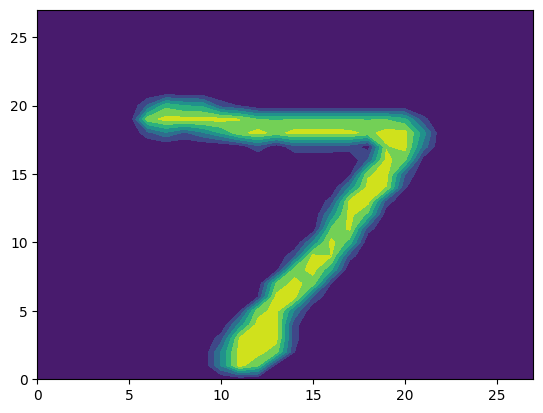

In [70]:
item_index = 0
print(y_test[item_index],'\n') # Print the label
print(X_test[item_index],'\n') # Print the matrix of values
plt.contourf(np.rot90(X_test[item_index].transpose())) # Make a contour plot of the matrix values
plt.show()

1 

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  77 254
  107   3   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  19 227 254
  254   9   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  81 254 254
  165   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   

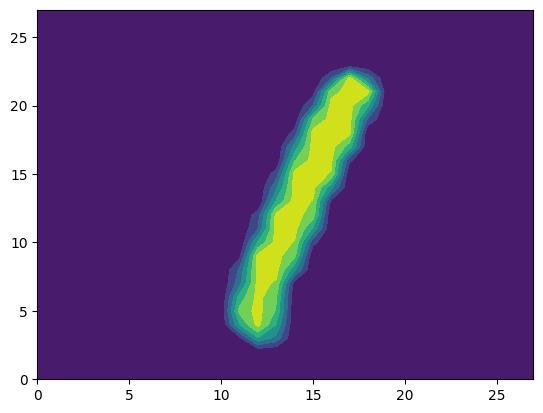

In [71]:
item_index = 5
print(y_test[item_index],'\n') # Print the label
print(X_test[item_index],'\n') # Print the matrix of values
plt.contourf(np.rot90(X_test[item_index].transpose())) # Make a contour plot of the matrix values
plt.show()

We will use an already denoised and preprocessed version of the training data.

In [72]:
Z_train = pd.read_parquet('Z_train.parquet', engine='pyarrow')
Z_test = pd.read_parquet('Z_test.parquet', engine='pyarrow')

## **Question 1 (5 points):**
## What is the shape of X_train and X_test?

## What is the shape of X_train[i] and X_test[i] for each index i?
Hint: All elements of X_train and X_test have the same shape, so you can report the shape of just the first element (i=0)

## What is the shape of Z_train and Z_test?

## What is the shape of y_train and y_test?

## Call the shape function in the code cell below and list your final answers in a text markdown cell.

In [73]:
print(X_train.shape)
print(X_test.shape)

print(X_train[0].shape)
print(X_test[0].shape)

print(Z_train.shape)
print(Z_test.shape)

print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(28, 28)
(28, 28)
(60000, 784)
(10000, 784)
(60000,)
(10000,)


* X_train shape: (60000, 28, 28)
* X_test shape: (10000, 28, 28)
* X_train[i] shape: (28, 28)
* X_test[i] shape: (28, 28)
* Z_train shape: (60000, 784)
* Z_test shape: (10000, 784)
* y_train shape: (60000,)
* y_test shape: (10000,)

## **Question 2 (5 points):**
## Run the cell below to determine the optimal k number of neighbors from the outputted graph. Report the optimal number and why you believe it is the optimal number in the text markdown cell.

In [74]:
k_bar = 10
k_grid = np.arange(0, k_bar) # The range of k's to consider
accuracy = np.zeros(k_bar) # Empty list of accuracies for each k to update

Fitting k=0
Fitting k=1
Fitting k=2
Fitting k=3
Fitting k=4
Fitting k=5
Fitting k=6
Fitting k=7
Fitting k=8
Fitting k=9
[2]


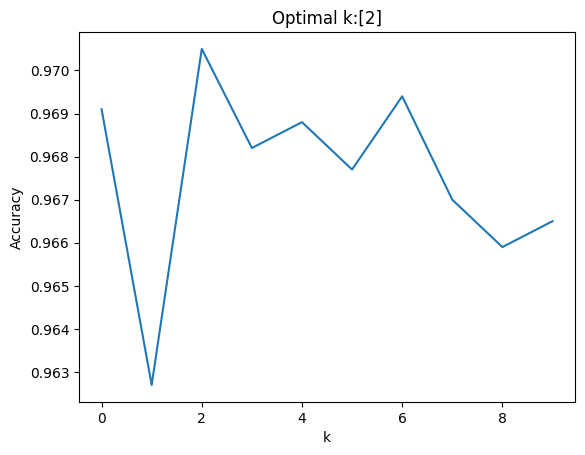

In [75]:
for k in range(k_bar):
    print(f"Fitting k={k}")
    knn = KNeighborsClassifier(n_neighbors=k+1)
    predictor = knn.fit(Z_train.values,y_train)
    accuracy[k] = knn.score(Z_test.values,y_test)

accuracy_max = np.max(accuracy) # Highest recorded accuracy
max_index = np.where(accuracy==accuracy_max)
k_star = k_grid[max_index] # Find the optimal value of k
print(k_star)

plt.plot(np.arange(0,k_bar),accuracy) # Plot accuracy by k
plt.xlabel("k")
plt.title("Optimal k:"+str(k_star))
plt.ylabel('Accuracy')
plt.show()

The most optimal number of neighbors is 2. This may be due to the model tending to overfit when k is small. This means the model is too sensitive to the noise in training data. This k value of 2 may also best minimize both bias and variance for the model.

## **Question 3 (10 points):**
## Instantiate and fit a KNN classifier with the optimal number of neighbors from above. Call predict on this KNN model using Z_test. Plot a confusion matrix for the KNN's performance on the test dataset using sklearn's ConfusionMatrixDisplay function.

## In a text markdown cell, explain which mistakes are most likely according to your confusion matrix. Which digits are more likely to be confused for each other? Do you find any interesting patterns?
Write a minimum of 5 sentences.

In [83]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9627

<Figure size 800x600 with 0 Axes>

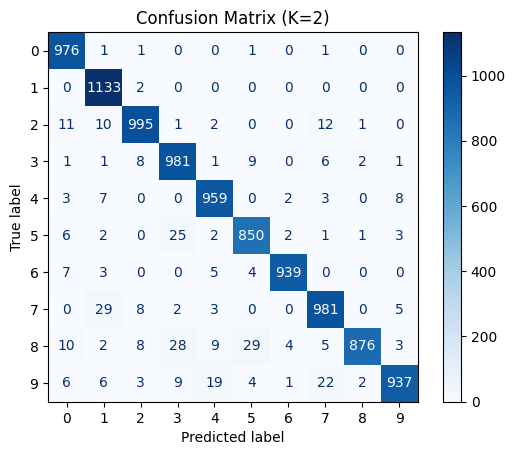

In [84]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix (K=2)')
plt.show()

There are many common mistakes when classifying numbers. For instance, in the confusion matrix, the digit 8 is frequently misclassified as 2, the digit 5 is often misclassified as 3, and the digit 7 is often misclassified as 0. This matrix is generally dominant in the diagonal, which is expected, meaning that the model performs well overall. However, the confusion tends to occur with the visually similar digits. For example, 2 and 8 share similar curvatures in their shapes. It seems that digit 1 has the highest accuracy, showing that there has been 1133 correct predictions out of 1135 total instances. The digit with the lowest accuracy is 8.

## **Question 4 (10 points):**
## ROC curves are typically used to distinguish between two classes by plotting the true positive rate (TPR) against the false positive rate (FPR) at different threshold settings. We will recode the target labels to be only 2 classes: "8" or "not 8"

## Fit a new KNN using binary_y_train and call predict using binary_y_test. Plot the ROC curve and print the AUC score for the new binary data whose code is below.

## Write 2 sentences on how to interpret the resulting ROC curve.

In [85]:
def recode_array(arr, value):
  recoded = np.where(arr == value, 1, 0)
  return recoded

In [86]:
binary_y_train = recode_array(y_train, 8)
binary_y_test = recode_array(y_test, 8)

In [87]:
# Original target: all digits 0 to 9
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [88]:
# New target: all values are 1 (digit 8) or 0 (all other digits)
binary_y_train

array([0, 0, 0, ..., 0, 0, 1])

In [91]:
model1 = KNeighborsClassifier(n_neighbors=2)
model1.fit(X_train, binary_y_train)
y_pred = model1.predict(X_test)

fpr, tpr, thresholds = roc_curve(binary_y_test, y_pred)

auc_score = roc_auc_score(binary_y_test, y_pred)
auc_score

0.946848279053303

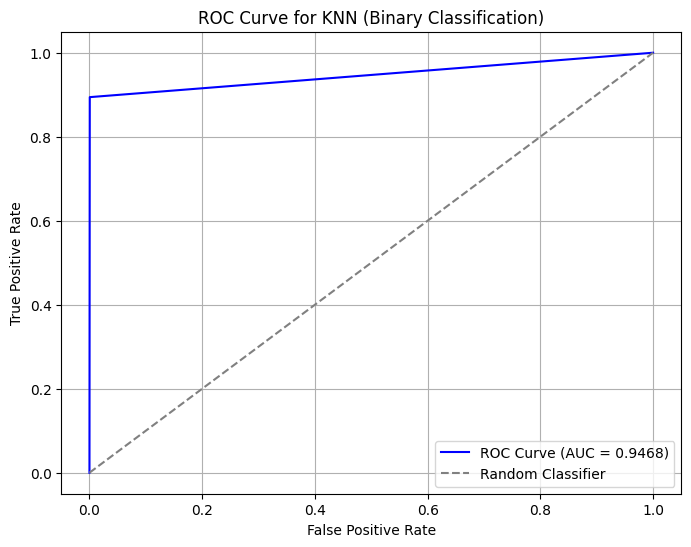

In [92]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN (Binary Classification)')
plt.legend()
plt.grid()
plt.show()

The ROC curve demonstrates that the KNN model performs significantly better than just random guessing, shown by the curve bowing towards the top-left corner. The ideal ROC curve would go straight up the y-axis, which this curve does for a majority of the curve, meaning it correctly identifies most cases, indicaitng a higher true positives and lower false positives. This is also proven by the high AUC score of 0.9468.

## Part 3: Sampling and Cross Validation (40 points)

We will use the following synthetic dataset to explore cross validation on.

In [93]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## **Question 1 (5 points):** Fit a vanilla KNN classifier on the training set and evaluate (predict) on the test set. Store the accuracy of this model in a variable called test_score.



In [94]:
# K-Nearest Neighbor Model
neigh2 = KNeighborsClassifier(n_neighbors=10)

neigh2.fit(X_train, y_train)
y_pred = neigh2.predict(X_test)

test_score = accuracy_score(y_test, y_pred)
test_score

0.8933333333333333


## **Question 2 (10 points):**
## Perform 10-fold cross-validation and compare the results of single split vs. 10-fold cross-validation by plotting accuracy (y-axis) against fold number (x-axis).

## Describe the effect of different fold numbers on the results of cross validation in a text markdown cell and if the results are expected. Give the average accuracy of CV scores across all folds.
Write a minimum of 2 sentences.

In [95]:
model = MultinomialNB()

X_train_abs = abs(X_train)
y_train_abs = abs(y_train)

# 10-fold Cross-Validation
cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_10_scores = cross_val_score(model, X_train_abs, y_train_abs, cv=cv_10, scoring='accuracy')

model.fit(X_train_abs, y_train_abs)

MultinomialNB()

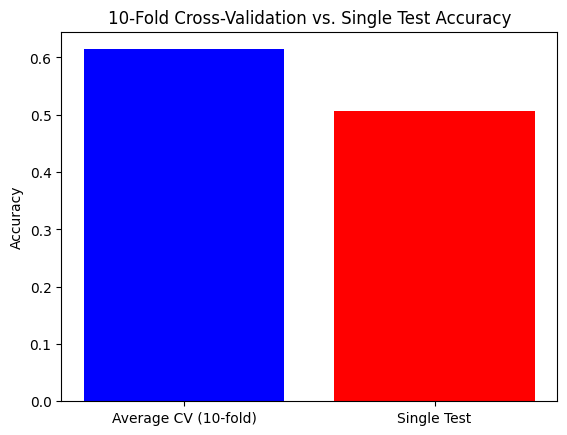

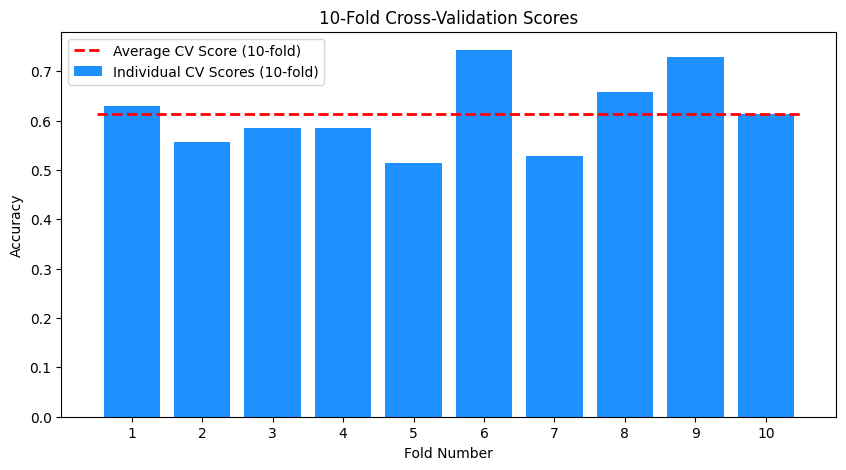

In [96]:
test_score_10 = model.score(X_test, y_test)

plt.bar(['Average CV (10-fold)', 'Single Test'], [np.mean(cv_10_scores), test_score_10], color=['blue', 'red'])
plt.ylabel('Accuracy')
plt.title('10-Fold Cross-Validation vs. Single Test Accuracy')
plt.show()

plt.figure(figsize=(10, 5))
x_range = np.arange(1, len(cv_10_scores) + 1)
plt.bar(x_range, cv_10_scores, color='dodgerblue', label='Individual CV Scores (10-fold)')
plt.plot([0.5, len(cv_10_scores) + 0.5], [np.mean(cv_10_scores)]*2, 'r--', label='Average CV Score (10-fold)', linewidth=2)
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('10-Fold Cross-Validation Scores')
plt.xticks(x_range)
plt.legend()
plt.show()

The first plot shows that the average accuracy from the 10-fold is higher than the single test accuracy. This was expected because cross validation typically provides a more robust estimate of the model's performance since it averages results across multiple splits of the data.

The second graph highlights the inconsistent model performances across different number of folds.

## **Question 3 (5 points):** ##
## Modify the plot above and add:
1. A horizontal static red line corresponding to the single split model accuracy
2. A horizontal green line corresponding to the average CV fold accuracy

## You may use the following code to achieve these:
> plt.axhline(y=test_score, color='r', linestyle='--', label='Single Test Score')

> plt.axhline(y=np.mean(cv_scores), color='g', linestyle='-', label='Average CV Score')



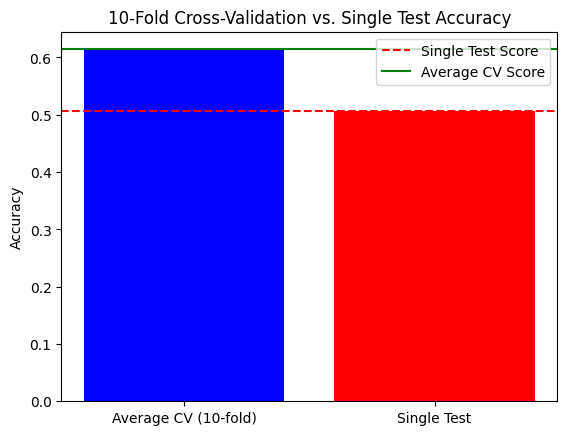

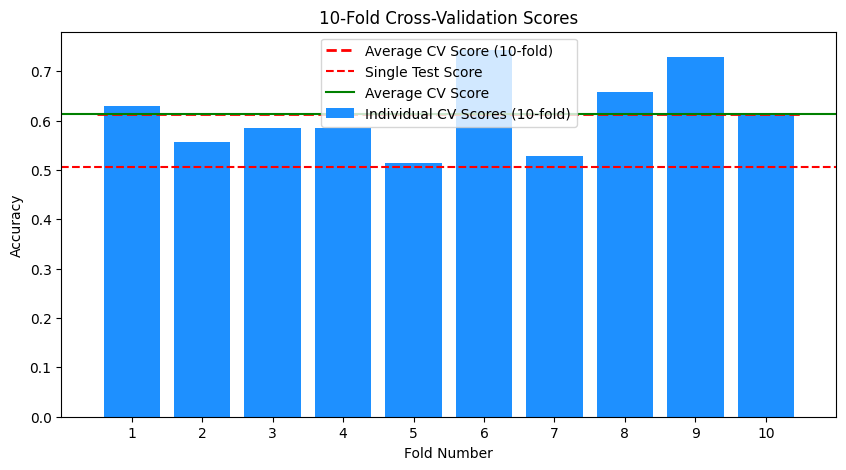

In [97]:
# Plot for 10-Fold Cross-Validation vs. Single Test Accuracy
plt.bar(['Average CV (10-fold)', 'Single Test'], [np.mean(cv_10_scores), test_score_10], color=['blue', 'red'])
plt.axhline(y=test_score_10, color='r', linestyle='--', label='Single Test Score')  # Red line for Single Test Accuracy
plt.axhline(y=np.mean(cv_10_scores), color='g', linestyle='-', label='Average CV Score')  # Green line for Average CV Score
plt.ylabel('Accuracy')
plt.title('10-Fold Cross-Validation vs. Single Test Accuracy')
plt.legend()
plt.show()

# Plot for 10-Fold Cross-Validation Scores
plt.figure(figsize=(10, 5))
x_range = np.arange(1, len(cv_10_scores) + 1)
plt.bar(x_range, cv_10_scores, color='dodgerblue', label='Individual CV Scores (10-fold)')
plt.plot([0.5, len(cv_10_scores) + 0.5], [np.mean(cv_10_scores)]*2, 'r--', label='Average CV Score (10-fold)', linewidth=2)
plt.axhline(y=test_score_10, color='r', linestyle='--', label='Single Test Score')  # Red line for Single Test Accuracy
plt.axhline(y=np.mean(cv_10_scores), color='g', linestyle='-', label='Average CV Score')  # Green line for Average CV Score
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('10-Fold Cross-Validation Scores')
plt.xticks(x_range)
plt.legend()
plt.show()

## **Question 4 (10 points):**
## Implement 5-fold cross-validation on a dataset of your choice. Complete any necessary preprocessing (you may reuse the dataset from Part 1).

## Implement a train-test split and instantiate a classification model of your choice. Call predict on (evaluate) both a single-split and 5-fold CV model.

In [98]:
X = clean_df.drop(columns=['Gender'])
y = clean_df['Gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [99]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
y_pred_single = model.predict(X_test)
accuracy_single = accuracy_score(y_test, y_pred_single)

In [100]:
cv_5_scores = cross_val_score(model, X, y, cv=5)
accuracy_cv_5 = np.mean(cv_5_scores)
accuracy_cv_5

0.6479999999999999

## **Question 5 (10 points):**
## Finally, create the same plot as in Question 3 to compare single-split with CV performance on your chosen dataset.

## The plot should have Fold Number on the x-axis and Accuracy on the y-axis. Include a horizontal red line for the single-split accuracy and a horizontal green line for the average CV fold score.

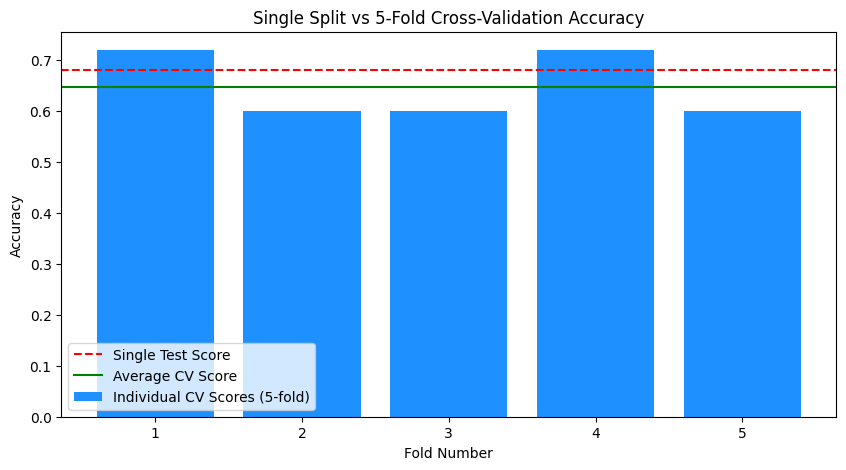

In [101]:
plt.figure(figsize=(10, 5))
x_range = np.arange(1, len(cv_5_scores) + 1)
plt.bar(x_range, cv_5_scores, color='dodgerblue', label='Individual CV Scores (5-fold)')
plt.axhline(y=accuracy_single, color='r', linestyle='--', label='Single Test Score')
plt.axhline(y=accuracy_cv_5, color='g', linestyle='-', label='Average CV Score')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('Single Split vs 5-Fold Cross-Validation Accuracy')
plt.xticks(x_range)
plt.legend()
plt.show()

### Honor Pledge

On my honor as a student, I have neither given nor received unauthorized aid on this assignment.